# Задача локализации и детекции объектов

<img src="https://www.researchgate.net/profile/Jose-Maria-Lahoz-Bengoechea/publication/343163234/figure/fig1/AS:916487858581505@1595519141334/Object-detection-task-where-objects-in-an-image-are-located-and-classified-Redmon-et_W640.jpg">

Сегодня разговор пойдет о задаче локализации и детекции объектов


**Постановка**

Дано N классов объектов, которые могут присутствовать на картинке.

Задача: ответить на вопрос, присутствуют ли указанные объекты на картинке (детекция) и если да, то указать расположение этих объектов на картинке с помощью габаритной рамки (локализация).


## Немного истории

Данная задача всегда представляла повышенный интерес в компьютерном зрении: при анализе реальных картинок часто использование классификационных нейросетей недостаточно.

### Подходы на основе sliding window

<image src="https://www.researchgate.net/publication/266215670/figure/fig1/AS:669537766744083@1536641651568/Object-detection-by-sliding-window-approach.png">

Это один из самых старых и самых простых подходов.

Идея: обучить какой-нибудь классификатор для картинок.

Далее, разбить исследуемую картинку на несколько участков и прогнать их через классификатор. Зная вывод классификатора и координаты участка, можно установить расположение искомого объекта.

**Плюсы:** нет необходимости менять имеющиеся уже архитектуры, можно использовать обученные классификаторы.

**Минусы:** большая вычислительная сложность, необходимость многократного запуска классификатора на исходной картинке. Нет гарантии, что искомый объект "уместится" в вырезанный участок.

### Подходы на основе "угадывания" потенциально значимых регионов

Подобные подходы стали набирать популярность с развитием сверточных нейросетей.

С ростом сложности классификационных алгоритмов подход на основе sliding window стал невыполним. Поэтому стали набирать популярность двухэтапные системы локализации и детекции объектов:

 - Step 1: среди всех возможных участков картинки выбрать те, которые потенциально могут содержать нужные нам объекты (этот шаг может выполняться как с помощью нейронной сети, так и с помощью более простых и быстрых алгоритмов).

 - Step 2: по выбранным на предыдущем шаге участкам пройтись классификатором (сверточным) и таким образом решить задачу локализации и детекции.

  **Архитектуры**
  - [R-CNN](https://arxiv.org/pdf/1311.2524v5) - regions with CNN features: потенциально интересные области находятся с помощью классических алгоритмов компьютерного зрения, потом идет стадия классификации с помощью сверточной сети (AlexNet).

  <image src="https://www.researchgate.net/profile/Neeraj-Bokde/publication/341099304/figure/fig4/AS:888908552359938@1588943722119/RCNN-architecture-17_W640.jpg">

  - [Fast R-CNN](https://arxiv.org/pdf/1504.08083): потенциально интересные области находятся с помощью специально обученной сверточной сети, затем подаются на вход обученному классификатору (на основе VGG).

  <img src="https://media.geeksforgeeks.org/wp-content/uploads/20200219160147/fast-RCNN1-1024x416.png">

  - [Faster R-CNN](https://arxiv.org/pdf/1506.01497): поиск потенциально интересных областей объединен с классификатором в одну нейронную сеть. Такая модель позволила находить объекты в реальном времени.

  <img src="https://production-media.paperswithcode.com/methods/Screen_Shot_2020-05-24_at_5.10.31_PM.png">

# Архитектура  YOLO

Архитектура YOLO появилась в 2016 году, впоследствии было выпущено огромное множество модификаций. На 2024 год опубликовано десять версий этой архитектуры ([yolov10 repository](https://github.com/THU-MIG/yolov10), [статья](https://arxiv.org/abs/2405.14458)).

Ключевые особенности сети: полностью сверточная архитектура, изображение проходит через нейросеть РОВНО один раз (You Only Look Once).

Концептуально такая модель похожа на первую часть сегментационной модели UNet (часть энкодер).

<img src="https://cdn.prod.website-files.com/614c82ed388d53640613982e/65391d490bf668d51d6f11af_yolov1.webp">

Вывод нейросети состоит из SxS ячеек. Каждая ячейка может кодировать локализацию одного объекта.

То есть, такая нейросеть может детектировать не более SxS предметов на картинке!

В модели YOLOv3 `S=19`, то есть нейросеть способна найти порядка 400 объектов на картинке.

**Могут ли ячейки предсказывать одни и те же объекты?**

Да, могут, и это проблема.

### Фильтрация предсказаний

Каждая ячейка SxS - это вектор, кодирующий предсказание расположения ассоциированного объекта. В нем хранится следующая информация:
 - вероятность того, что предсказание **в принципе** представляет интерес (от 0 до 1),
 - 4 координаты для т.н. bounding box (габаритной обводящей рамки): координаты одного угла по x и y, длина по x и по y.
 - вероятности присутствия каждого класса: если наша сеть умеет локализовывать 10 классов, то далее идет 10 координат, каждая из которых отражает вероятность расположения в указанном прямоугольнике каждого объекта.

Если мы осуществляем детекцию и локализацию 5 различных классов, то вектор предсказаний для каждой ячейки выглядит так:
$$(P_{interest}, X_{corner}, Y_{corner}, H, W, P_{1}, P_{2}, P_{3}, P_4, P_5).$$

$$\sum_{i=1}^5 P_i = 1, \quad P_i \ge 0.$$

Первичная фильтрация предсказаний осуществляется на основе $P_{interest}$: если он ниже установленного порога (нпр. 0.3), то вся ячейка с ее предсказаниями игнорируется. Так отсеиваются неуверенные ответы нейросети.

Далее необходимо побороться с возможными дубликатами предсказаний: соседние ячейки вполне могут локализовать один и тот же объект.

### Non-maximum suppression

Пусть мы отфильтровали все неуверенные предсказания. Тогда нам осталось только избавиться от дубликатов.

Нам поможет алгоритм non-maximum suppression.
Для каждой пары рамок, кодирующих один и тот же объект, мы посчитаем intersection over union. Если рамки очень сильно накладываются друг на друга, то их IoU высокий (нпр. > 0.6). С другой стороны:

<img src="https://cdn.analyticsvidhya.com/wp-content/uploads/2020/07/graphic4.jpg">

то есть если перекрытия рамок большие, то скорее всего, они обводят один и тот же реальный объект (одного человека, одну машину и тд.). Это значит, что для таких пар взаимопересекающихся рамок мы можем убрать все, кроме одной.

Так и сделаем: среди взаимопересекающихся рамок оставим только ту, у которой вероятность $P_{interest}$ наивысшая. Остальные рамки уберем, предполагая, что они дублируют уже имеющееся предсказание.

### Обучение YOLO

Функция потерь YOLO состоит из нескольких слагаемых:
- регрессионная часть для 4 координат bounding box - MSE(pred, true).
- классификационная часть для корректного предсказания класса внутри рамки,
- классификационная часть для предсказания $P_{interest}$ интереса выбранной рамки.


Код для обучения YOLO уже написан и перенесен в библиотеку ultralytics, поэтому мы не будем его разбирать.

### Установка аннотатора

На своем компьютере (НЕ в колабе) в терминале выполните следующие команды ([официальная страница библиотеки тут](https://labelstud.io/guide/quick_start)):

```pip install label-studio```

```label-studio start```

### Работа с YOLO в pytorch

In [ ]:
!wget https://github.com/THU-MIG/yolov10/archive/refs/heads/main.zip
!unzip main.zip

--2024-08-27 15:27:53--  https://github.com/THU-MIG/yolov10/archive/refs/heads/main.zip
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/THU-MIG/yolov10/zip/refs/heads/main [following]
--2024-08-27 15:27:53--  https://codeload.github.com/THU-MIG/yolov10/zip/refs/heads/main
Resolving codeload.github.com (codeload.github.com)... 140.82.121.10
Connecting to codeload.github.com (codeload.github.com)|140.82.121.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘main.zip’

main.zip                [ <=>                ]   1.58M  10.4MB/s    in 0.2s    

2024-08-27 15:27:53 (10.4 MB/s) - ‘main.zip’ saved [1652077]

Archive:  main.zip
cd2f79c70299c9041fb6d19617ef1296f47575b1
   creating: yolov10-main/
  inflating: yolov10-main/.gitignore  
  inflating: yolov10-main/.pre-c

In [ ]:
!mv yolov10-main/ yolov10

In [ ]:

#!pip install -r yolov10-main/requirements.txt
!pip install -e ./yolov10

Obtaining file:///content/yolov10
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for ultralytics (pyproject.toml) ... done
  Created wheel for ultralytics: filename=ultralytics-8.1.34-0.editable-py3-none-any.whl size=20539 sha256=f69e573ed8cbc456d11c06162c61d5c3b73f2c3005facb4861d09ca63c9e2d2b
  Stored in directory: /tmp/pip-ephem-wheel-cache-3l4vlmf3/wheels/51/93/e8/22d2e815ced343915c15d86b2a00d95eb0a997d012527fbea7
Successfully built ultralytics


In [ ]:
import sys
sys.path.append('yolov10')

from ultralytics import YOLOv10

model = YOLOv10.from_pretrained('jameslahm/yolov10s') # s - small, m - medium, l - large

#model.val(data='coco.yaml', batch=256)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.72k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/32.7M [00:00<?, ?B/s]

In [ ]:
dir(model)

['T_destination',
 '__annotations__',
 '__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_apply',
 '_backward_hooks',
 '_backward_pre_hooks',
 '_buffers',
 '_call_impl',
 '_check_is_pytorch_model',
 '_compiled_call_impl',
 '_decode_arg',
 '_encode_arg',
 '_forward_hooks',
 '_forward_hooks_always_called',
 '_forward_hooks_with_kwargs',
 '_forward_pre_hooks',
 '_forward_pre_hooks_with_kwargs',
 '_from_pretrained',
 '_get_backward_hooks',
 '_get_backward_pre_hooks',
 '_get_hub_session',
 '_get_name',
 '_hub_mixin_coders',
 '_hub_mixin_config',
 '_hub_mixin_config',
 '_hub_mixin_info',
 '_hub_mixin_init_parameter

In [ ]:
res = model.predict(source='egor.jpg')


image 1/1 /content/egor.jpg: 640x640 1 person, 17.3ms
Speed: 2.5ms preprocess, 17.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
?model.train

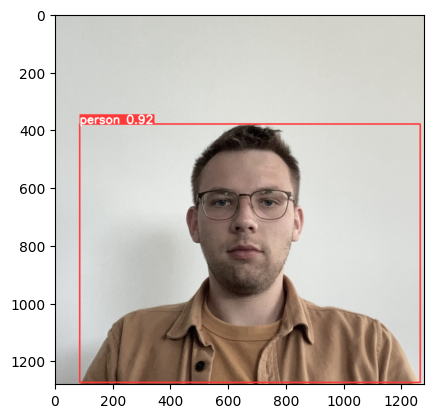

In [ ]:
plt.imshow(res[0].plot()[:,:, ::-1])